### Data Augmentation + Regression
Using Keras data augmentation utilities to generate more data. A simple CNN to predict the coins sum.




In [1]:
#https://www.kaggle.com/lgmoneda/data-augmentation-regression

In [2]:
#pip install tensorflow

In [3]:
# memory footprint support libraries/code
#ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#pip install gputil
#pip install psutil
#pip install humanize
import psutil
import humanize

In [4]:
import numpy as np 
import pandas as pd 

In [5]:
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from time import time
from time import sleep

In [6]:
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


### Taking a look at the images

In [7]:
# Open a train file 
folder = "geekhub-2020-age-estimation-challenge/train_images"

onlyfiles_train = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
df_train =  pd.read_csv("geekhub-2020-age-estimation-challenge/train.csv")
df_train

,id,age
0,0,5
1,1,4
2,2,17
3,3,4
4,4,14
...,...,...
681,681,13
682,682,6
683,683,38
684,684,2


Working with 686 images
Image examples: 
00040.jpg


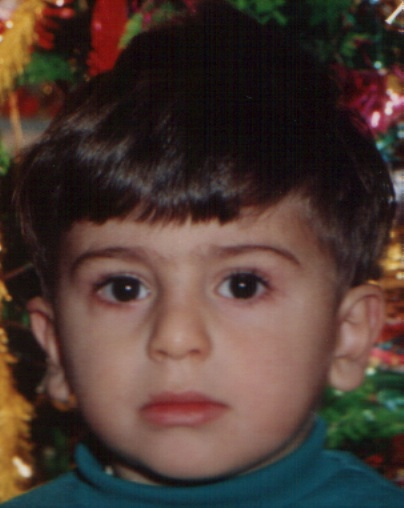

00041.jpg


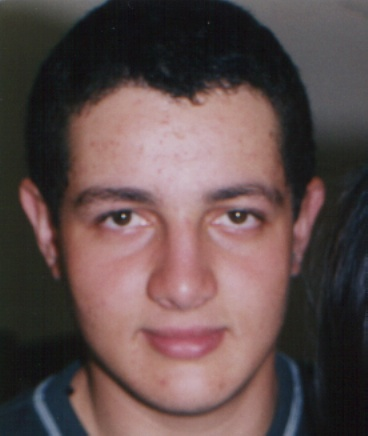

00042.jpg


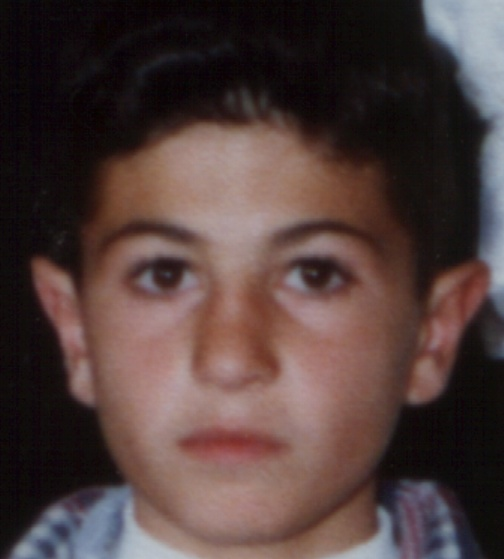

00043.jpg


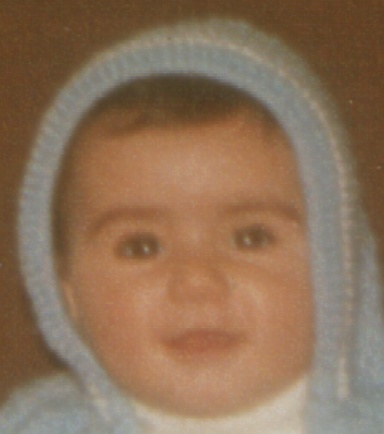

00044.jpg


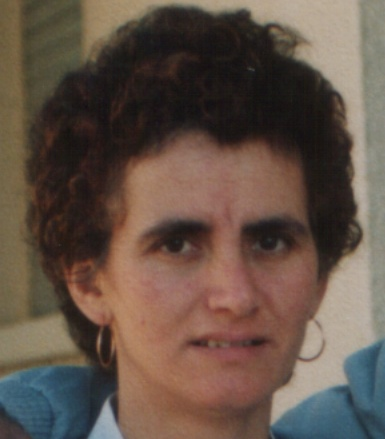

00045.jpg


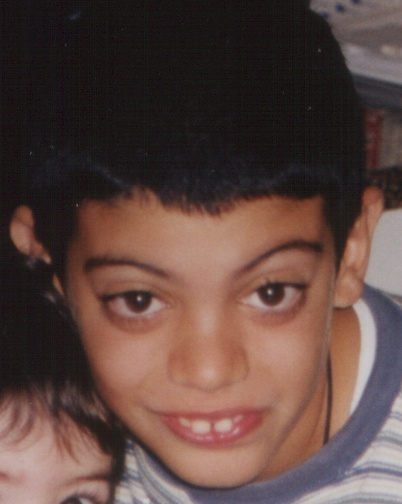

00046.jpg


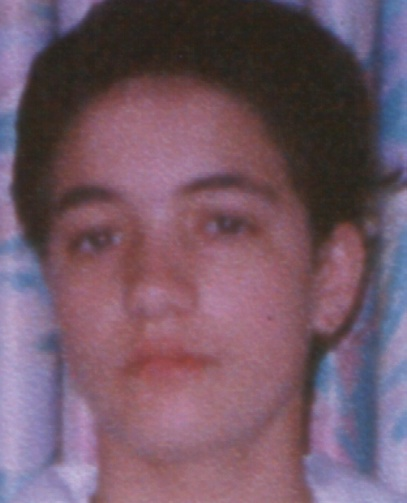

00047.jpg


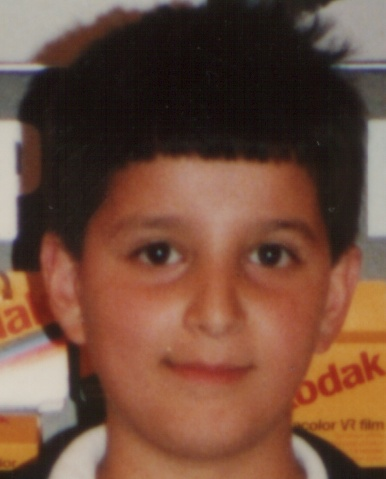

00048.jpg


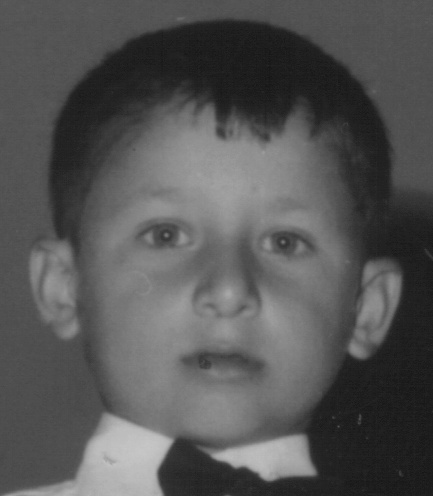

00049.jpg


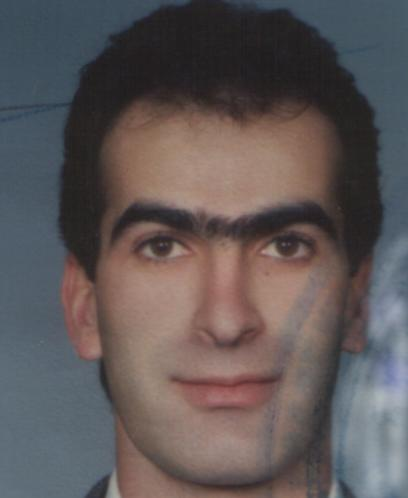

In [37]:

print("Working with {0} images".format(len(onlyfiles_train)))
print("Image examples: ")

for i in range(40, 50):
    print(onlyfiles_train[i])
    display(_Imgdis(filename=folder + "/" + onlyfiles_train[i], width=240, height=320))

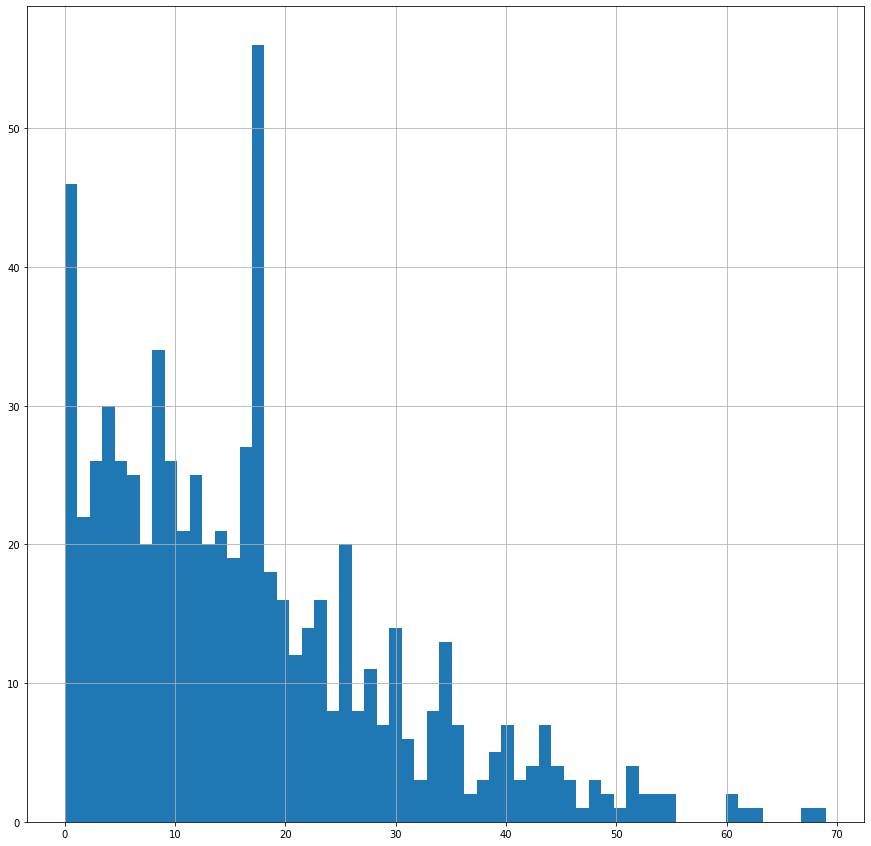

In [9]:
#look at the answer 'age'(disbalance)
histogram_age = df_train['age'].hist(bins=df_train['age'].nunique(), figsize=(15, 15))

### From imgs to numpy array

In [10]:
%%time

train_files = []
y_train = df_train['age'].values
i=0
for _file in onlyfiles_train:
    train_files.append(_file)
    
print("Files in train_files: %d" % len(train_files))


Files in train_files: 686
Wall time: 0 ns


In [11]:
# Original Dimensions
image_width = 224
image_height = 224

#image_width = int(image_width / ratio=4)
#image_height = int(image_height / ratio=4)

channels = 3
nb_classes = 1

dataset_train = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                     dtype=np.float32)
print(dataset_train.shape)
i = 0
for file in train_files:
    #print(file)
    img = load_img(folder + "/" + _file, target_size=(224, 224))  # this is a PIL image   
    img.thumbnail((image_width, image_height))
    x = img_to_array(img)  
 
    dataset_train[i] = x
    i += 1
    if i % 250 == 0:
        print("%d images to array" % i)
print("All images to array!")

(686, 224, 224, 3)
250 images to array
500 images to array
All images to array!


In [19]:
type(dataset_train)

numpy.ndarray

In [12]:
dataset_train.shape

(686, 224, 224, 3)

### Data Augmentation

In [13]:
datagen = ImageDataGenerator(
        rotation_range=90,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

datagen.fit(dataset_train)

### Building a CNN

In [14]:
import tensorflow as tf

In [18]:
%%time
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

#def build_model():

model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=dataset_train[0].shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten()) 
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('linear'))
    
sgd = SGD(lr=0.01, decay=1e-7, momentum=.9)
early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
    
model.compile(loss='mse', optimizer='rmsprop',  metrics=['mae'])
    
    
#    return model

#mod= build_model()
model.fit(np.array(dataset_train), y_train, epochs=30)

Train on 686 samples
Epoch 1/30
686/686 [==============================] - 10s 15ms/sample - loss: 311.1731 - mae: 13.2965
Epoch 2/30
686/686 [==============================] - 9s 13ms/sample - loss: 207.7976 - mae: 11.1265
Epoch 3/30
686/686 [==============================] - 9s 13ms/sample - loss: 202.1523 - mae: 10.8690
Epoch 4/30
686/686 [==============================] - 9s 13ms/sample - loss: 205.2573 - mae: 11.0130
Epoch 5/30
686/686 [==============================] - 11s 16ms/sample - loss: 202.2218 - mae: 11.0787
Epoch 6/30
686/686 [==============================] - 9s 14ms/sample - loss: 191.5816 - mae: 10.6022
Epoch 7/30
686/686 [==============================] - 10s 15ms/sample - loss: 196.7798 - mae: 10.7533
Epoch 8/30
686/686 [==============================] - 11s 17ms/sample - loss: 202.6955 - mae: 10.9161
Epoch 9/30
686/686 [==============================] - 10s 14ms/sample - loss: 206.1482 - mae: 11.1263
Epoch 10/30
686/686 [==============================] - 10s 15ms/s

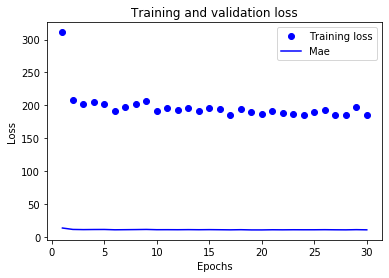

Wall time: 386 ms


In [20]:
%%time
import matplotlib.pyplot as plt
#history = model.fit(np.array(dataset_train), df_train['age'].values, epochs=30)

history_dict = model.history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['mae']
epochs = range(1, len(val_loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Mae')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
score = age_model.fit_generator(datagen.flow(
            train_x[ix_train], train_y[ix_train], batch_size=128)
            , epochs=1
            , validation_data=(test_x, test_y)
            #, callbacks=[checkpointer]
        )
        
scores.append(score)
        
val_loss_change = []; loss_change = []
for i in range(0, len(scores)):
    val_loss_change.append(scores[i].history['val_loss'])
    loss_change.append(scores[i].history['loss'])

plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

NameError: name 'scores' is not defined

### Prediction to test data

In [22]:
%%time 
#test data

folder_2 = "geekhub-2020-age-estimation-challenge/test_images"

onlyfiles_test = [f for f in os.listdir(folder_2) if os.path.isfile(os.path.join(folder_2, f))]

test_files = []
for _file in onlyfiles_test:
    test_files.append(_file)
    
print("Files in train_files: %d" % len(test_files))

Files in train_files: 316
Wall time: 36 ms


In [31]:
# Original Dimensions test
dataset_test = np.ndarray(shape=(len(test_files), image_height, image_width, channels),
                     dtype=np.float32)

channels = 3
nb_classes = 1
print(dataset_test.shape)
i = 0
for _file in test_files:
    
    img = load_img(folder_2 + "/" + _file, target_size=(224, 224))  # this is a PIL image   
    img.thumbnail((image_width, image_height))
    x = img_to_array(img)  

    dataset_test[i] = x
    i += 1
    if i % 250 == 0:
        print("%d images to array" % i)
print("All test images to array!")

(316, 224, 224, 3)
250 images to array
All test images to array!


In [27]:
dataset_train

array([[[[179., 169., 157.],
         [180., 170., 158.],
         [180., 170., 158.],
         ...,
         [178., 171., 155.],
         [180., 173., 157.],
         [178., 171., 155.]],

        [[180., 170., 158.],
         [180., 170., 158.],
         [180., 170., 158.],
         ...,
         [180., 172., 159.],
         [178., 170., 157.],
         [181., 174., 158.]],

        [[182., 172., 160.],
         [182., 172., 160.],
         [181., 171., 159.],
         ...,
         [176., 168., 155.],
         [176., 168., 155.],
         [177., 169., 156.]],

        ...,

        [[154., 151., 136.],
         [152., 149., 134.],
         [151., 149., 134.],
         ...,
         [163., 160., 145.],
         [163., 160., 145.],
         [164., 161., 146.]],

        [[155., 152., 137.],
         [154., 151., 136.],
         [153., 150., 135.],
         ...,
         [161., 158., 143.],
         [161., 158., 143.],
         [164., 161., 144.]],

        [[159., 156., 141.],
       

In [32]:
from math import sqrt

predictions_dataset_test = model.predict(np.array(dataset_test))

In [33]:
predictions_dataset_test

array([[13.758357 ],
       [13.330743 ],
       [18.466791 ],
       [15.207093 ],
       [15.763726 ],
       [10.9649315],
       [21.2328   ],
       [17.438341 ],
       [19.215975 ],
       [18.514715 ],
       [15.711588 ],
       [21.369743 ],
       [19.42339  ],
       [15.617197 ],
       [12.860787 ],
       [13.267119 ],
       [16.188387 ],
       [15.108014 ],
       [15.144024 ],
       [15.886903 ],
       [15.731554 ],
       [12.072828 ],
       [19.438416 ],
       [16.473137 ],
       [14.986794 ],
       [14.116881 ],
       [21.332443 ],
       [16.6203   ],
       [18.939283 ],
       [13.815546 ],
       [17.753479 ],
       [16.180683 ],
       [11.101715 ],
       [18.554401 ],
       [12.585952 ],
       [14.054472 ],
       [17.7402   ],
       [14.200617 ],
       [20.396065 ],
       [16.933641 ],
       [18.829025 ],
       [18.60236  ],
       [17.510353 ],
       [17.374176 ],
       [14.0043125],
       [17.627287 ],
       [16.015682 ],
       [15.53

In [35]:
df1 =  pd.read_csv("geekhub-2020-age-estimation-challenge/sample_submission.csv")
df1['age']=predictions_dataset_test

In [36]:
df1.to_csv("geekhub-2020-age-estimation-challenge/p2_ep30",  columns = ['id', 'age'], index=False)